# NSGA-II Benchmark Notebook

This fresh notebook rebuilds the NSGA-II benchmarking workflow using the refactored
VAMOS package layout. It relies on the programmatic `StudyRunner` utilities so you can
queue problem and backend combinations, reproduce CLI experiments, and visualize the
results interactively.

The CLI now exposes --nsgaii-crossover, --nsgaii-mutation, and --nsgaii-repair flags so you can reproduce variation studies without editing the notebook. Pick SBX vs. BLX, polynomial vs. non-uniform mutation, and a repair strategy to match CLI smoke tests.

Example (BLX + non-uniform + reflect repair):
`powershell
python -m vamos.main --problem zdt1 --max-evaluations 2000 --nsgaii-crossover blx_alpha --nsgaii-crossover-alpha 0.35 --nsgaii-crossover-prob 0.85 --nsgaii-mutation non_uniform --nsgaii-mutation-perturbation 0.4 --nsgaii-mutation-prob 1/n --nsgaii-repair reflect
`

Use the same knobs inside StudyRunner blocks to keep CLI and notebook experiments consistent.


In [25]:
import sys
import itertools
from types import SimpleNamespace
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def resolve_project_root(markers=("pyproject.toml", ".git")):
    current = Path.cwd().resolve()
    for candidate in (current, *current.parents):
        if any((candidate / marker).exists() for marker in markers):
            return candidate
    raise RuntimeError("No se pudo ubicar la raiz del proyecto; ejecuta este notebook dentro del arbol de VAMOS.")

PROJECT_ROOT = resolve_project_root()
SRC_DIR = PROJECT_ROOT / "src"
if SRC_DIR.exists() and str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

from vamos import main as vamos_main
from vamos.problem.registry import make_problem_selection
from vamos.study.runner import StudyRunner, StudyTask

plt.style.use("seaborn-v0_8-darkgrid")


In [26]:
POPULATION_SIZE = vamos_main.POPULATION_SIZE
MAX_EVALUATIONS = vamos_main.MAX_EVALUATIONS
DEFAULT_SEEDS = [vamos_main.SEED]

PROBLEM_GRID = [
    {"problem": "zdt1", "label": "ZDT1 (2 obj)", "n_var": 10},    
    #{"problem": "dtlz2", "label": "DTLZ2 (3 obj)", "n_var": 12, "n_obj": 3},
]

INCLUDE_EXTERNAL_BASELINES = False
EXTERNAL_PROBLEM_SOURCE = "native"  # choose "vamos" to wrap internal problems

def detect_engines(candidates):
    engines = []
    for name in candidates:
        try:
            vamos_main._resolve_kernel(name)
        except Exception as exc:
            print(f"Skipping engine '{name}': {exc}")
        else:
            engines.append(name)
    return engines


ENABLED_ENGINES = detect_engines(["numpy", "numba", "moocore", "moocore_v2", "moocore_v3", "moocore_v4",  "moocore_v5"])
if not ENABLED_ENGINES:
    raise RuntimeError("No kernel backends available. Install optional extras or adjust the list above.")

AVAILABLE_EXTERNAL = list(vamos_main.EXTERNAL_ALGORITHM_NAMES)
print(f"Benchmarks will use engines: {', '.join(ENABLED_ENGINES)}")
if INCLUDE_EXTERNAL_BASELINES and AVAILABLE_EXTERNAL:
    print(
        "External baselines enabled: "
        + ", ".join(AVAILABLE_EXTERNAL)
        + f" (problem source={EXTERNAL_PROBLEM_SOURCE})"
    )


Benchmarks will use engines: numpy, numba, moocore, moocore_v2, moocore_v3, moocore_v4, moocore_v5


In [27]:
RUN_HISTORY = []

def build_tasks(problems, engines, seeds):
    entries = []
    for spec in problems:
        for engine in engines:
            for seed in seeds:
                entries.append(
                    StudyTask(
                        algorithm="nsgaii",
                        engine=engine,
                        problem=spec["problem"],
                        n_var=spec.get("n_var"),
                        n_obj=spec.get("n_obj"),
                        seed=seed,
                    )
                )
    return entries


def run_external_baselines(problems):
    rows = []
    history = []
    if not INCLUDE_EXTERNAL_BASELINES or not AVAILABLE_EXTERNAL:
        return rows, history

    use_native = EXTERNAL_PROBLEM_SOURCE == "native"
    for spec in problems:
        try:
            selection = make_problem_selection(
                spec["problem"], n_var=spec.get("n_var"), n_obj=spec.get("n_obj")
            )
        except ValueError as exc:
            print(f"Skipping external baselines for {spec['problem']}: {exc}")
            continue

        for alg in AVAILABLE_EXTERNAL:
            print(f"[External] {alg} on {selection.spec.label}")
            try:
                metrics = vamos_main._execute_external_runner(
                    alg,
                    selection,
                    use_native_problem=use_native,
                )
            except ValueError as exc:
                print(f"  {exc}")
                continue
            if metrics is None:
                continue
            rows.append(
                {
                    "problem": selection.spec.key,
                    "label": selection.spec.label,
                    "engine": metrics["engine"],
                    "algorithm": metrics["algorithm"],
                    "seed": vamos_main.SEED,
                    "time_ms": metrics["time_ms"],
                    "evaluations": metrics["evaluations"],
                    "evals_per_sec": metrics["evals_per_sec"],
                    "hv": metrics.get("hv"),
                    "hv_source": metrics.get("hv_source"),
                    "spread": metrics.get("spread"),
                }
            )
            history.append(
                SimpleNamespace(
                    selection=selection,
                    metrics=metrics,
                    task=SimpleNamespace(seed=vamos_main.SEED),
                )
            )
    return rows, history


def run_tasks(tasks, *, export_csv=None):
    global RUN_HISTORY
    RUN_HISTORY = []
    records = []
    runner = StudyRunner(verbose=True)
    tasks_sorted = sorted(tasks, key=lambda t: t.problem)
    export_csv = Path(export_csv) if export_csv else None

    for problem_key, group in itertools.groupby(tasks_sorted, key=lambda t: t.problem):
        group_tasks = list(group)
        print(f"\n=== Running problem: {problem_key} ({len(group_tasks)} tasks) ===")
        export_path = None
        if export_csv is not None:
            export_path = export_csv.with_name(f"{export_csv.stem}_{problem_key}{export_csv.suffix}")
        results = runner.run(group_tasks, export_csv_path=export_path)
        RUN_HISTORY.extend(results)
        for res in results:
            metrics = res.metrics
            records.append(
                {
                    "problem": res.selection.spec.key,
                    "label": res.selection.spec.label,
                    "engine": metrics["engine"],
                    "algorithm": metrics["algorithm"],
                    "seed": res.task.seed,
                    "time_ms": metrics["time_ms"],
                    "evaluations": metrics["evaluations"],
                    "evals_per_sec": metrics["evals_per_sec"],
                    "hv": metrics.get("hv"),
                    "hv_source": metrics.get("hv_source"),
                    "spread": metrics.get("spread"),
                }
            )

    extra_rows, extra_history = run_external_baselines(PROBLEM_GRID)
    records.extend(extra_rows)
    RUN_HISTORY.extend(extra_history)

    df = pd.DataFrame.from_records(records)
    return df, list(RUN_HISTORY)


In [28]:
tasks = build_tasks(PROBLEM_GRID, ENABLED_ENGINES, DEFAULT_SEEDS)
summary_df, latest_results = run_tasks(tasks)
summary_df.sort_values(["problem", "engine"], inplace=True)
summary_df



=== Running problem: zdt1 (7 tasks) ===
[Study] (1/7) nsgaii | numpy | zdt1 | seed=42
VAMOS: Vectorized Architecture for Multiobjective Optimization Studies
Problem: ZDT1
Description: Classic bi-objective benchmark with a convex Pareto front.
Decision variables: 10
Objectives: 2
Encoding: continuous
Algorithm: NSGAII
Backend: numpy
Population size: 100
Offspring population size: 100
Max evaluations: 25000
--------------------------------------------------------------------------------
Algorithm finished
--------------------------------------------------------------------------------
PERFORMANCE RESULTS:
Total time: 534.09 ms
Evaluations: 25000
Evaluations/second: 46809
Final solutions: 100

SOLUTION QUALITY:
  Objective 1 range: [0.000000, 0.999997]
  Objective 2 range: [0.000109, 1.029017]
  Approximate front spread in f1: 1.434798

Results stored in: results\ZDT1\nsgaii\numpy\seed_42
[Study] (2/7) nsgaii | numba | zdt1 | seed=42
VAMOS: Vectorized Architecture for Multiobjective Opti

,problem,label,engine,algorithm,seed,time_ms,evaluations,evals_per_sec,hv,hv_source,spread
2,zdt1,ZDT1,moocore,nsgaii,42,111.3621,25000,224492.893003,0.920577,MooCoreKernel,1.434798
3,zdt1,ZDT1,moocore_v2,nsgaii,42,99.8692,25000,250327.428278,0.921477,MooCoreKernelV2,1.408849
4,zdt1,ZDT1,moocore_v3,nsgaii,42,92.7794,25000,269456.366397,0.919783,MooCoreKernelV3,1.384158
5,zdt1,ZDT1,moocore_v4,nsgaii,42,97.4297,25000,256595.268180,0.919783,MooCoreKernelV4,1.384158
6,zdt1,ZDT1,moocore_v5,nsgaii,42,96.1752,25000,259942.272019,0.919783,MooCoreKernelV5,1.384158
1,zdt1,ZDT1,numba,nsgaii,42,99.3328,25000,251679.203646,0.920643,NumbaKernel,1.447644
0,zdt1,ZDT1,numpy,nsgaii,42,534.0880,25000,46808.765597,0.920577,NumPyKernel,1.434798


In [29]:
required_cols = {'problem_label', 'engine'}
if summary_df.empty or not required_cols.issubset(summary_df.columns):
    missing = required_cols - set(summary_df.columns)
    msg = 'No hay datos para graficar por backend.' if summary_df.empty else f"Faltan columnas: {', '.join(sorted(missing))}"
    print(msg)
else:
    for (label, backend), group in summary_df.groupby(['problem_label', 'engine'], sort=False):
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        fig.suptitle(f"{label} - {backend}")

        axes[0].bar(group['algorithm'], group['hv'], color='tab:green')
        axes[0].set_ylabel('Hypervolumen')
        axes[0].set_title('Calidad')
        axes[0].tick_params(axis='x', rotation=30)

        axes[1].bar(group['algorithm'], group['time_ms'], color='tab:red')
        axes[1].set_ylabel('Tiempo (ms)')
        axes[1].set_title('Rendimiento')
        axes[1].tick_params(axis='x', rotation=30)

        fig.tight_layout()
        plt.show()

Faltan columnas: problem_label


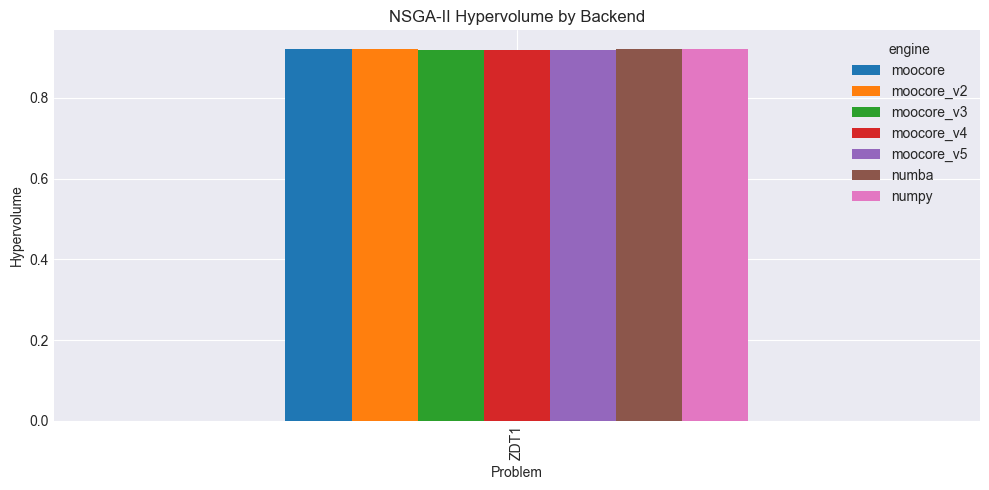

In [30]:
if not summary_df.empty:
    pivot = summary_df.pivot(index="label", columns="engine", values="hv")
    ax = pivot.plot(kind="bar", figsize=(10, 5))
    ax.set_ylabel("Hypervolume")
    ax.set_xlabel("Problem")
    ax.set_title("NSGA-II Hypervolume by Backend")
    plt.tight_layout()
    plt.show()
else:
    print("No data to visualize yet. Run the cell above to generate results.")


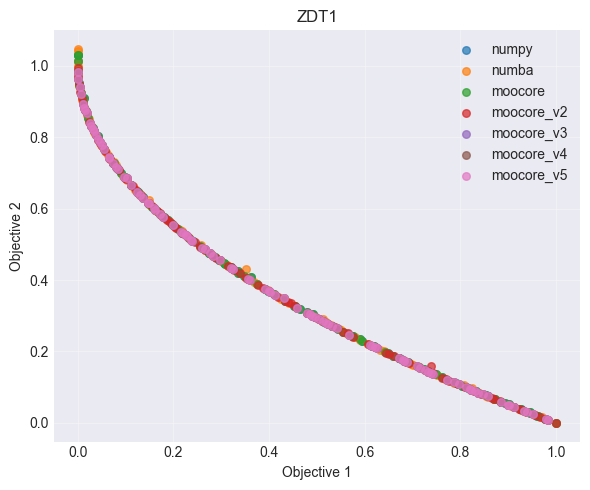

In [31]:
if not RUN_HISTORY:
    print("No results available yet. Run the benchmarking cell above first.")
else:
    problems = {}
    for res in RUN_HISTORY:
        problems.setdefault(res.selection.spec.label, []).append(
            (res.metrics["engine"], res.metrics["F"], res.selection.n_obj)
        )
    for label, entries in problems.items():
        fig, ax = plt.subplots(figsize=(6, 5))
        for engine, front, n_obj in entries:
            front = np.asarray(front)
            dims = front.shape[1]
            coords = front[:, : min(2, dims)]
            ax.scatter(coords[:, 0], coords[:, 1], s=30, alpha=0.7, label=engine)
            if dims > 2:
                ax.set_title(f"{label} (showing first 2 of {dims} objectives)")
            else:
                ax.set_title(label)
        ax.set_xlabel("Objective 1")
        ax.set_ylabel("Objective 2")
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()


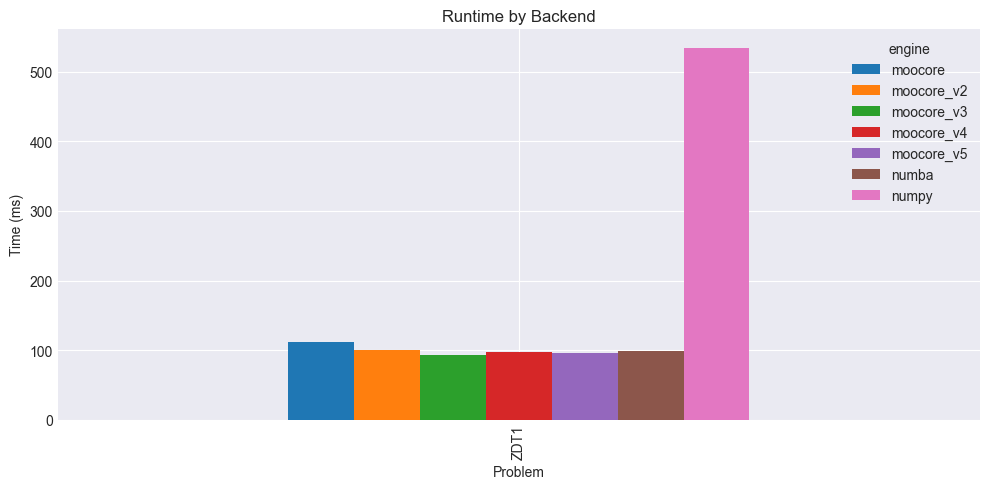

In [32]:
if summary_df.empty:
    print("No summary data yet. Run the benchmarking cell above first.")
else:
    pivot_time = summary_df.pivot(index="label", columns="engine", values="time_ms")
    ax = pivot_time.plot(kind="bar", figsize=(10, 5))
    ax.set_ylabel("Time (ms)")
    ax.set_xlabel("Problem")
    ax.set_title("Runtime by Backend")
    plt.tight_layout()
    plt.show()
